#### Data Preprocessing

In [ ]:
# bdd100k to coco

In [ ]:
# coco to yolo

##### Train

In [1]:
import sys, os
sys.path.append(os.path.abspath("LiteMono"))

import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import json

from ultralytics import YOLO
import networks
from layers import disp_to_depth
from options import LiteMonoOptions


def detect_objects(img, yolo_model):
    results = yolo_model(img)
    bbox_tensor = results[0].boxes.xyxy.cpu().numpy()
    cls_tensor = results[0].boxes.cls.cpu().numpy()
    return bbox_tensor, cls_tensor


def estimate_depth(img, encoder, depth_decoder, gt_depths, feed_width, feed_height,
                   original_width, original_height, device):
    
    input_image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).convert('RGB')
    input_image = input_image.resize((feed_width, feed_height), Image.LANCZOS)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_tensor)
        outputs = depth_decoder(features)
        disp = outputs[("disp", 0)]
        
        scaled_disp, _ = disp_to_depth(disp, 1e-3, 80)
        pred_disp = scaled_disp.squeeze().cpu().numpy()
        
        scale_ratios = []
        for gt_depth in gt_depths:
            gt_h, gt_w = gt_depth.shape[:2]
            pred_disp_resized = cv2.resize(pred_disp, (gt_w, gt_h))
            pred_depth_temp = 1.0 / pred_disp_resized

            mask = np.logical_and(gt_depth > 1e-3, gt_depth < 80)
            if np.count_nonzero(mask) == 0:
                continue
            ratio = np.median(gt_depth[mask]) / np.median(pred_depth_temp[mask])
            scale_ratios.append(ratio)
        
        global_scale = np.median(scale_ratios)

        pred_depth = 1.0 / cv2.resize(pred_disp, (original_width, original_height))
        pred_depth *= global_scale

    return pred_depth

def calculate_risk_score(frame, encoder, depth_decoder, yolo_model, gt_depths, feed_width,
                               feed_height, device, labels, risk_baseline):

    if isinstance(frame, np.ndarray): 
        orig_img = frame
    elif isinstance(frame, str):
        orig_img = cv2.imread(frame)

    original_height, original_width = orig_img.shape[:2]

    bbox_tensor, cls_tensor = detect_objects(orig_img, yolo_model)
    if bbox_tensor is None or cls_tensor is None or len(bbox_tensor)==0:
        return None
    
    pred_depth = estimate_depth(orig_img, encoder, depth_decoder, gt_depths,
                                feed_width, feed_height, original_width, original_height, device)

    depth_map_resized = cv2.resize(pred_depth, (original_width, original_height), interpolation=cv2.INTER_LINEAR)
    
    objects_info = []
    for i, bbox in enumerate(bbox_tensor):
        x1, y1, x2, y2 = bbox.astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(original_width, x2), min(original_height, y2)
        if x2 <= x1 or y2 <= y1:
            continue
        
        depth_crop = depth_map_resized[y1:y2, x1:x2]
        if depth_crop.size == 0:
            continue
        
        min_val = float(np.min(depth_crop))
        center_x = (x1 + x2) / 2.0
        
        if center_x < original_width / 3:
            location = 'left'
        elif center_x < 2 * original_width / 3:
            location = 'center'
        else:
            location = 'right'
        
        class_idx = cls_tensor[i]
        if class_idx < len(labels):
            class_name = labels[int(class_idx)]
        else:
            class_name = "others"
        
        baseline = risk_baseline.get(class_name, 1.0)
        epsilon = 1e-3  
        risk_score = baseline * (1.0 / (min_val + epsilon))  
        
        bbox_coords = (x1, y1, x2, y2)
        objects_info.append((class_name, location, risk_score, min_val, bbox_coords))
    
    if len(objects_info) == 0:
        return None

    best_obj = max(objects_info, key=lambda obj: obj[2])
    return best_obj

def plot_max_risk_bbox(frame, best_obj):
    if isinstance(frame, str):
        class_name, location, risk_score, min_depth, bbox = best_obj
        x1, y1, x2, y2 = bbox

        img = cv2.imread(frame)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(img_rgb)
        
        label = f"{class_name} | {location} | Risk: {risk_score:.2f} | MinD: {min_depth:.2f}"
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, color='lime', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    elif isinstance(frame, np.ndarray): 

        class_name, location, risk_score, min_depth, bbox = best_obj
        x1, y1, x2, y2 = bbox
        display_frame = frame.copy()
        cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  
        label = f"{class_name} | {location} | Risk: {risk_score:.2f} | MinD: {min_depth:.2f}"
        cv2.putText(display_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 2)
        return display_frame


/Users/seong-eunseon/opt/anaconda3/envs/yolo/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
risk_baseline = {
    'person': 30.0,
    'car': 50.0,
    'rider': 40.0,
    'bus': 50.0,
    'truck': 50.0,
    'bike': 40.0,
    'motor': 40.0,
    'traffic light': 20.0,
    'traffic sign': 20.0
}

yolo_model = YOLO("./models/best.pt")

sys.argv = [sys.argv[0],
            '--load_weights_folder', '../lite-mono_640x192/',
            '--data_path', '../100k/',
            '--model', 'lite-mono']

options = LiteMonoOptions()
opt = options.parse()  
opt.load_weights_folder = './models/lite-mono_640x192/'
opt.data_path = '../100k/'
opt.model = 'lite-mono'
opt.post_process = False  
opt.min_depth = 1e-3
opt.max_depth = 80
opt.device = 'cpu'
encoder_path = os.path.join(opt.load_weights_folder, "encoder.pth")
decoder_path = os.path.join(opt.load_weights_folder, "depth.pth")

print('enc', encoder_path)
encoder_dict = torch.load(encoder_path, map_location=opt.device)
decoder_dict = torch.load(decoder_path, map_location=opt.device)

feed_width = encoder_dict['width']
feed_height = encoder_dict['height']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = networks.LiteMono(model="lite-mono", height=feed_height, width=feed_width)
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in encoder.state_dict()})
encoder.to(device)
encoder.eval()

depth_decoder = networks.DepthDecoder(encoder.num_ch_enc, scales=range(3))
depth_decoder.load_state_dict({k: v for k, v in decoder_dict.items() if k in depth_decoder.state_dict()})
depth_decoder.to(device)
depth_decoder.eval()

# ground truth depth
gt_data = np.load('./gt_depths.npz', fix_imports=True, encoding='latin1', allow_pickle=True)
gt_depths = gt_data["data"]

json_file = 'bdd100k_labels_images_train_coco.json' 

with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

labels = []
for item in data['categories']:
    label = item.get('name')
    if label:
        labels.append(label)

enc ./models/lite-mono_640x192/encoder.pth


In [5]:
img_path = "./val_tmp/b1cac6a7-04e33135.jpg"
result = calculate_risk_score(
    frame=img_path,
    encoder=encoder,
    depth_decoder=depth_decoder,
    yolo_model=yolo_model,
    gt_depths=gt_depths,
    feed_width=feed_width,
    feed_height=feed_height,
    device=device,
    labels=labels,
    risk_baseline=risk_baseline,
)

obj_class, loc, risk, _ , _ = result
print("===========================================================")
print(f"Object: {obj_class}, Location: {loc}, Risk: {risk:.2f}")

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


0: 384x640 12 cars, 330.7ms
Speed: 13.7ms preprocess, 330.7ms inference, 17.1ms postprocess per image at shape (1, 3, 384, 640)
Object: car, Location: center, Risk: 6.20


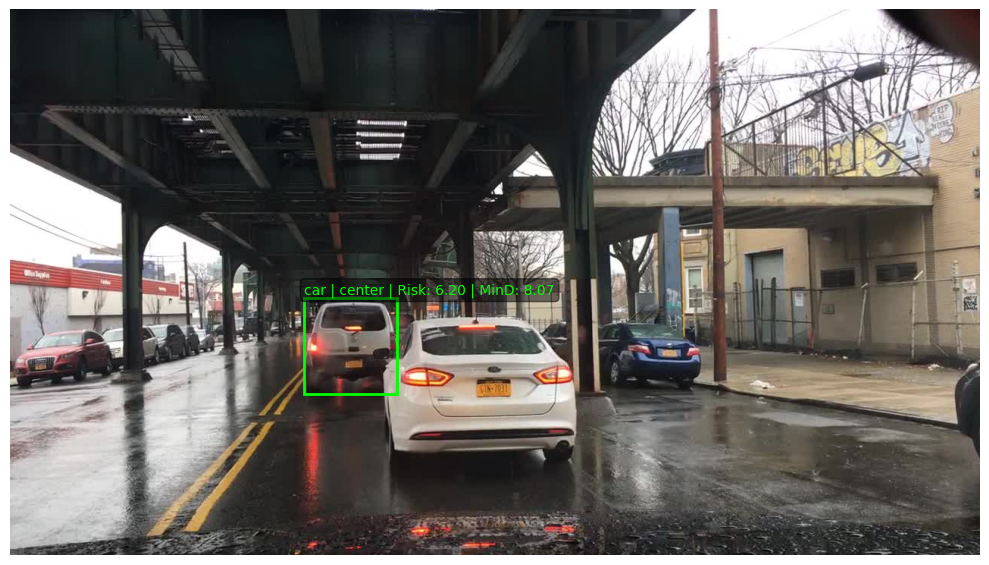

In [6]:
plot_max_risk_bbox(img_path, result)

In [ ]:
import cv2
import sys
video_path = "../test/cross_stop2.mp4" 
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Failed to open video file")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    best_obj = calculate_risk_score(frame, encoder, depth_decoder, yolo_model,
                                            gt_depths, feed_width, feed_height, device,
                                            labels, risk_baseline)
    if best_obj is not None:
        frame = plot_max_risk_bbox(frame, best_obj)
    
    cv2.imshow('Real-Time Object Detection', frame)
    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 7 persons, 7 cars, 6 traffic lights, 4 traffic signs, 125.4ms
Speed: 2.4ms preprocess, 125.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 8 cars, 8 traffic lights, 3 traffic signs, 233.9ms
Speed: 1.8ms preprocess, 233.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 8 cars, 7 traffic lights, 2 traffic signs, 140.7ms
Speed: 22.9ms preprocess, 140.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


KeyboardInterrupt: 